Process dataset to obtain multimodal inputs

# Import dependency

In [1]:
import pandas as pd
from rdkit import RDLogger
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw
from utils.helm_utils import get_cycpep_smi_from_helm

pd.set_option('display.max_colwidth', None)

def show_mol_from_smi_large(smi):
    mol = Chem.MolFromSmiles(smi)
    img = Draw.MolToImage(mol, size=(800, 800))
    display(img)

def count_n_monomers(helm):
    return len(helm.split('.')) + len(helm.split('{')) - 2

train = False

In [53]:
# plot the histogram of smi_len, helm_len, n_mono respectively

import matplotlib.pyplot as plt

def plot_lengths(df):
    f, axs = plt.subplots(1, 3, figsize=(15, 4))

    df['smi_len'].hist(bins=50, ax=axs[0])
    axs[0].set_title('smi_len')

    df['helm_len'].hist(bins=50, ax=axs[1])
    axs[1].set_title('helm_len')


    df['n_mono'].hist(bins=range(df['n_mono'].min(), df['n_mono'].max()), ax=axs[2])
    axs[2].set_title('n_mono')
    plt.show()

# plot_lengths(df_cycpdb_all)

# Cyclic peptides from CycPeptMPDB
Process all HELMS in DF to get SMILES

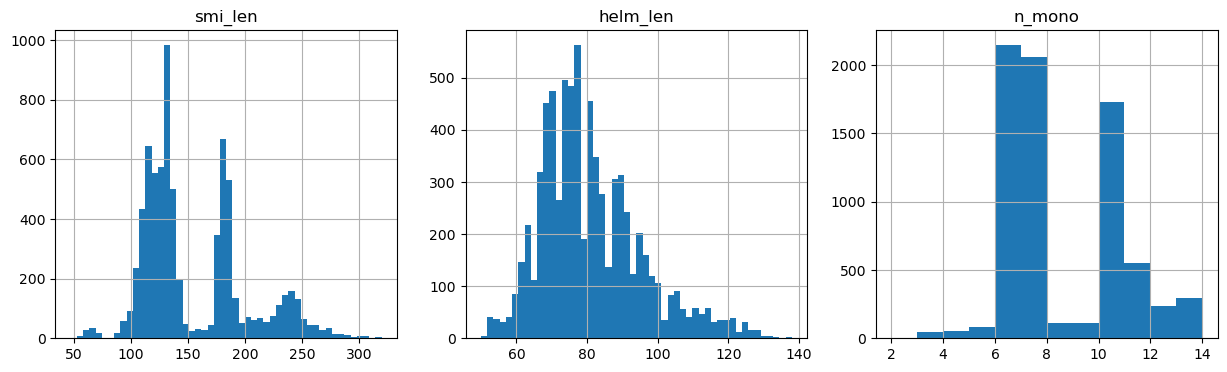

7451 5960 1491


In [44]:
# train = True
train = False

if train:
    cols = ['smi', 'helm', 'score', 'n_mono', 'is_cpp', 'smi_len', 'helm_len']
    df_cycpdb = pd.read_csv('data/CycPeptMPDB/CycPeptMPDB_Peptide_All_flt.csv')
    df_cycpdb['smi'] = [get_cycpep_smi_from_helm(helm) for helm in df_cycpdb.HELM]
    df_cycpdb_all = df_cycpdb[['smi', 'HELM', 'Permeability']].rename(columns={'HELM': 'helm', 'Permeability': 'score'})
    df_cycpdb_all['n_mono'] = [count_n_monomers(helm) for helm in df_cycpdb_all.helm]
    df_cycpdb_all['is_cpp'] = df_cycpdb_all.score >= -6
    df_cycpdb_all['smi_len'] = df_cycpdb_all.smi.str.len()
    df_cycpdb_all['helm_len'] = df_cycpdb_all.helm.str.len()

    from sklearn.model_selection import train_test_split
    df_cycpdb_train, df_cycpdb_test = train_test_split(df_cycpdb_all, test_size=0.2, random_state=42)
    
    df_cycpdb_all[cols].to_csv('data/CycPeptMPDB/all.csv', index=False)
    df_cycpdb_train[cols].to_csv('data/CycPeptMPDB/train.csv', index=False)
    df_cycpdb_test[cols].to_csv('data/CycPeptMPDB/test.csv', index=False)
else:
    df_cycpdb_all = pd.read_csv('data/CycPeptMPDB/all.csv')
    df_cycpdb_train = pd.read_csv('data/CycPeptMPDB/train.csv')
    df_cycpdb_test = pd.read_csv('data/CycPeptMPDB/test.csv')

plot_lengths(df_cycpdb_all)
print(len(df_cycpdb_all), len(df_cycpdb_train), len(df_cycpdb_test))


<AxesSubplot:>

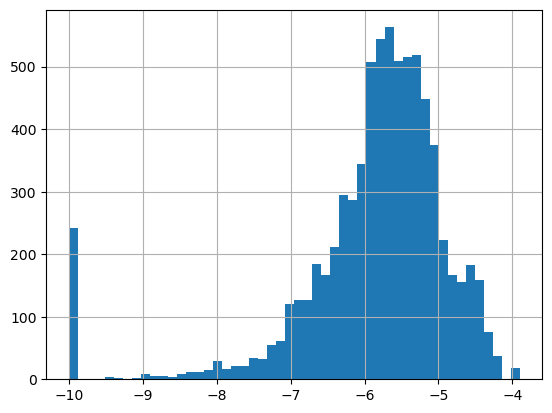

In [45]:
display(df_cycpdb_all['score'].hist(bins=50))

# Linear peptides from PeptideAtlas

In [9]:
# check if all amino acids are natural
def check_if_all_aas_are_natural(aa_seq):
    return all([aa in 'ACDEFGHIKLMNPQRSTVWY' for aa in aa_seq])

def get_is_natural_aa(df):
    return [check_if_all_aas_are_natural(seq) for seq in df.aa_seq]

def get_helm_from_aa_seq(aa_seq):
    aa_seq = '.'.join(aa_seq)
    return f'PEPTIDE1{{{aa_seq}}}$$$$'

def get_linpep_smi_from_aa_seq(aa_seq):
    if 'X' in aa_seq:
        return None
    
    mol = Chem.MolFromSequence(aa_seq)
    if mol:
        return Chem.MolToSmiles(mol)
    else:
        return None

In [10]:
def load_fasta_to_df(fa_path):
    line_list = []
    with open(fa_path, 'r') as f:
        line_list = f.readlines()
    
    ids, seqs = [], []
    for line in line_list:
        if line.startswith('>'):
            ids.append(line.strip().replace('>', ''))
            counter = 0
        else:
            seqs.append(line.strip())
            counter += 1
        
        if counter > 1:
            raise Exception(f'More than one line for sequence {id}')
    
    df = pd.DataFrame({'id': ids, 'aa_seq': seqs})
    return df

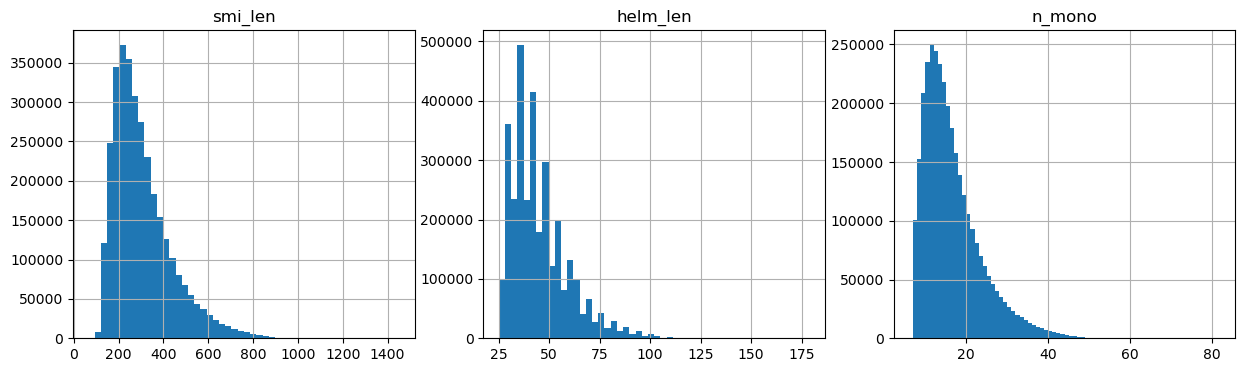

3238311

In [49]:
import pandas as pd
train = False

if train:
    cols = ['aa_seq', 'helm', 'smi', 'n_mono', 'smi_len', 'helm_len']
    # !ls ../Datasets/PeptideAtlas
    files = [
    'bburgdorferi_b31-201902-APD_BORBU_all.fasta',
    'celegans-201309-APD_Ce_all.fasta',
    'chicken-201607-APD_CHICK_all.fasta',
    'cow-201112-APD_Bt_all.fasta',
    'drosophila-201208-APD_Dm_all.fasta',
    'halobacterium-201308-APD_Ha_all.fasta',
    'honeybee-201309-APD_Apis_all.fasta',
    'horse-201304-APD_MYG_all.fasta',
    'Human-202012-APD_Hs_all.fasta',
    'leptospirainterrogans-201308-APD_Li_all.fasta',
    'mouse-201506-APD_Mm_all.fasta',
    'mtuberculosis-201307-APD_MTB_all.fasta',
    'pfalciparum-201209-APD_Pf_all.fasta',
    'pig-201411-APD_Pig_all.fasta',
    'rat-201311-APD_Rn_all.fasta',
    'staphylococcusaureuscol-201310-APD_STAAU_all.fasta',
    'staphylococcusaureushg001-201409-APD_STAAU_all.fasta',
    'streptococcus-200702-APD_Sp_all.fasta',
    'yeast-201303-APD_Sc_all.fasta',
    'zebrafish-201403-APD_Dr_all.fasta']

    for f in files:
        df = load_fasta_to_df(f'../Datasets/PeptideAtlas/{f}')
        df.to_csv(f'../Datasets/PeptideAtlas/csv/{f}.csv', index=False)

    df_pa = pd.concat([pd.read_csv(f'../Datasets/PeptideAtlas/csv/{f}.csv') for f in files])
    df_pa_redup = df_pa.drop_duplicates(subset=['aa_seq']).copy()

    print(len(df_pa), len(df_pa_redup))
    df_pa_redup['helm'] = [get_helm_from_aa_seq(seq) for seq in df_pa_redup.aa_seq]
    df_pa_redup['smi'] = [get_linpep_smi_from_aa_seq(seq) for seq in df_pa_redup.aa_seq]  # 43min 43s

    df_pa_redup['n_mono'] = [count_n_monomers(helm) for helm in df_pa_redup.helm]
    df_pa_redup['smi_len'] = df_pa_redup.smi.str.len()
    df_pa_redup['helm_len'] = df_pa_redup['helm'].str.len()
    df_pa_redup = df_pa_redup[~df_pa_redup.smi.isnull()]
    df_pa_redup[cols].to_csv('data/PeptideAtlas/all.csv', index=False)

else:
    df_pa_redup = pd.read_csv('data/pretrain/PeptideAtlas/all.csv')

plot_lengths(df_pa_redup)
len(df_pa_redup)


# HELMs from PubChem32

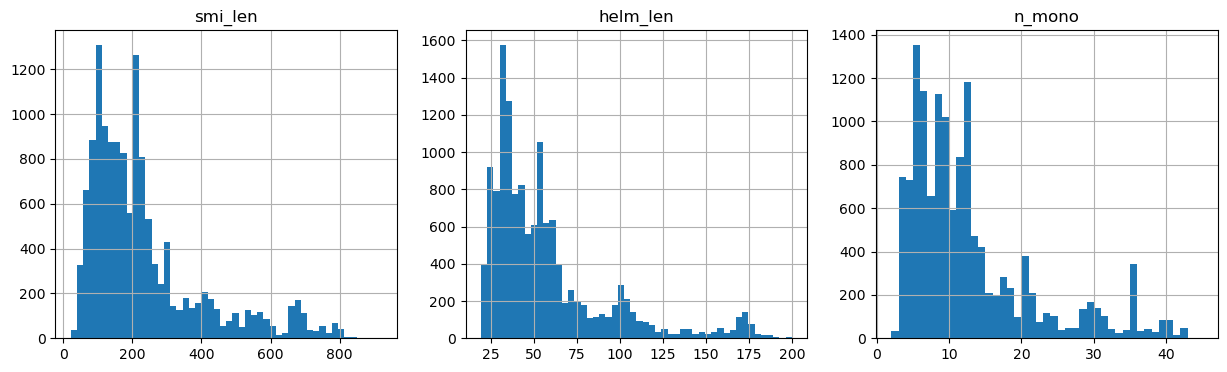

13679

In [52]:
# train = True
train = False

if train:
    df_pubchem = pd.read_csv('data/pretrain/chembl32/biotherapeutics_dict_prot_flt.csv')
    df_pubchem['n_mono'] = [count_n_monomers(helm) for helm in df_pubchem.HELM]
    df_pubchem = df_pubchem[['HELM', 'n_mono']].rename(columns={'HELM': 'helm'})

    df_pubchem['smi'] = [get_cycpep_smi_from_helm(helm) for helm in df_pubchem.helm]
    df_pubchem['smi_len'] = df_pubchem.smi.str.len()
    df_pubchem['helm_len'] = df_pubchem['helm'].str.len()
    print(len(df_pubchem[df_pubchem.smi.isna()]), len(df_pubchem))

    df_pubchem_smi = df_pubchem[~df_pubchem.smi.isna()]
    df_pubchem_smi.to_csv('data/pretrain/chembl32/all_w_smi.csv', index=False)

else:
    df_pubchem_smi = pd.read_csv('data/pretrain/chembl32/all_w_smi.csv')

plot_lengths(df_pubchem_smi)
len(df_pubchem_smi)

# Merge dataset to pretrain models

In [55]:
# train = True
train = False

if train:
    cols = ['helm', 'smi', 'n_mono']
    df_merged_helm = pd.concat([df_cycpdb_train[cols], df_pa_redup[cols], df_pubchem_smi[cols]], axis=0, ignore_index=True)
    df_merged_helm['helm_len'] = df_merged_helm['helm'].str.len()
    # df_merged_helm = df_merged_helm[df_merged_helm['helm_len'] <= 100]
    df_merged_helm['smi_len'] = df_merged_helm['smi'].str.len()
    df_merged_helm.to_csv('data/pretrain/merged/all.csv', index=False)

    from sklearn.model_selection import train_test_split

    df_merged_helm_train, df_merged_helm_test = train_test_split(df_merged_helm, test_size=0.05, random_state=42)
    df_merged_helm_train.to_csv('data/pretrain/merged/train.csv', index=False)
    df_merged_helm_test.to_csv('data/pretrain/merged/test.csv', index=False)

else:
    df_merged_helm = pd.read_csv('data/pretrain/merged/all.csv')
    df_merged_helm_train = pd.read_csv('data/pretrain/merged/train.csv')
    df_merged_helm_test = pd.read_csv('data/pretrain/merged/test.csv')

In [56]:
df_merged_helm.smi_len.max(), df_merged_helm.helm_len.max()

(1452, 200)